<img src=https://obis.org/images/logo.png width="300">  <img src=https://obis.org/images/ioc_logo.png width="80">

<div style="width: 100%; background-color: #0277d4;">&nbsp;</div>

# eDNA expeditions in UNESCO World Heritage Marine Sites

## SST data download from Copernicus

This file contains code to retrieve SST data in `parquet` format from the [Marine Copernicus](https://marine.copernicus.eu/) catalogue through the [WEkEO platform](https://www.wekeo.eu/). For alternatives without the use of WEkEO see the [GitHub repository](https://github.com/iobis/marineheritage-sst) of the environmental data component of the project.

Sea surface temperature is extracted from the Global Ocean OSTIA Sea Surface Temperature and Sea Ice Reprocessed product. More information can be found in the [data catalogue](https://data.marine.copernicus.eu/product/SST_GLO_SST_L4_REP_OBSERVATIONS_010_011/description).

### Team and contact
eDNA expeditions: https://www.unesco.org/en/edna-expeditions  
Team: Saara Suominem, Pieter Provoost, Ward Appeltans  
Environmental data download/processing: Silas Principe (s.principe@unesco.org)  



## Import libraries

The processing of the files in netCDF format is done by the `xarray` package. We also use `geopandas` to load the shapefile of the Marine Heritage sites, what enable us to cut the data for only the region we need.

Note: If you have problems loading any of the libraries, uncoment the next cell code and run the `pip install` commands.

In [ ]:
#!pip install netCDF4
#!pip install xarray
#!pip install geopandas
#!pip install regionmask
#!pip install matplotlib
#!pip install pyarrow

In [2]:
import xarray as xr
import numpy as np
import geopandas as gpd
import regionmask
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import os
import re
import glob
import shutil
from zipfile import ZipFile

## Load sample data

We start by opening a single dataset and exploring it. When working through WEkEO we can directly use the datasets that are saved on the server. You can explore it using the following command:

In [3]:
# List directories/files
os.listdir('eodata/CMEMS/REP/GLO/SST/SST_GLO_SST_L4_REP_OBSERVATIONS_010_011/2021/01/01')

['20210101120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB_REP-v02.0-fv02.0.nc']

In [4]:
# Open a single dataset
ds = xr.open_dataset('eodata/CMEMS/REP/GLO/SST/SST_GLO_SST_L4_REP_OBSERVATIONS_010_011/2021/01/01/20210101120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB_REP-v02.0-fv02.0.nc')
ds.analysed_sst

<xarray.DataArray 'analysed_sst' (time: 1, lat: 3600, lon: 7200)>
[25920000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01T12:00:00
  * lat      (lat) float32 -89.97 -89.93 -89.88 -89.82 ... 89.88 89.93 89.97
  * lon      (lon) float32 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -300
    valid_max:      4500
    source:         AMSR2-REMSS-L2P-v2.0, AMSRE-REMSS-L2P-v2.0, TMI-REMSS-L2P...
    reference:      C.J. Donlon, M. Martin,J.D. Stark, J. Roberts-Jones, E. F...
    comment:         OSTIA foundation SST

We also open the marine heritage sites shapefile, so we can select one region to explore.

In [6]:
# Open the marine heritage sites shapefile
# This was downloaded from https://github.com/iobis/mwhs-shapes
shape_area = gpd.read_file('marine_world_heritage.gpkg')
shape_area.head()

,name,source,source_original,buffer,geometry
0,Aldabra Atoll,Marine Regions,World Heritage Marine Programme,False,"MULTIPOLYGON (((46.43239 -9.35855, 46.45735 -9..."
1,Archipiélago de Revillagigedo,UNEP,None,False,"MULTIPOLYGON (((-114.68718 18.16876, -114.7395..."
2,Archipiélago de Revillagigedo,UNEP,None,True,"POLYGON ((-115.47139 17.65528, -110.07806 17.6..."
3,Area de Conservación Guanacaste,UNEP,None,False,"MULTIPOLYGON (((-85.57398 11.04824, -85.56947 ..."
4,Banc d'Arguin National Park,UNEP,None,False,"MULTIPOLYGON (((-16.06520 19.39622, -16.08443 ..."


<Axes: >

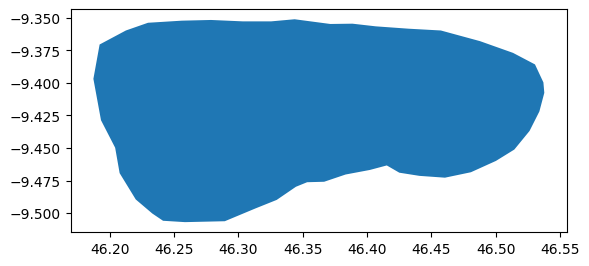

In [7]:
# We select only one to explore
sel_area = shape_area[getattr(shape_area, 'name') == str('Aldabra Atoll')]
sel_area.plot()

From the selected region and dataset, we can then crop the data to the region we need. First, however, we need to verify if the longitude is on the correct format and also rename some dimensions.

In [8]:
# Change longitude/latitude dimension names
sel_area_lat = [float(sel_area.total_bounds[1]), float(sel_area.total_bounds[3])]
sel_area_lon = [float(sel_area.total_bounds[0]), float(sel_area.total_bounds[2])]
  
if 'longitude' in ds.dims:
    ds = ds.rename({'longitude' : 'lon', 'latitude' : 'lat'})
if 'Longitude' in ds.dims:
    ds = ds.rename({'Longitude' : 'lon', 'Latitude' : 'lat'})
ds

<xarray.Dataset>
Dimensions:           (time: 1, lat: 3600, lon: 7200)
Coordinates:
  * time              (time) datetime64[ns] 2021-01-01T12:00:00
  * lat               (lat) float32 -89.97 -89.93 -89.88 ... 89.88 89.93 89.97
  * lon               (lon) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.4, ACDD-1.3
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    summary:                    A merged, multi-sensor L4 Foundation SST product
    references:                 Donlon, C.J., Martin, M., Stark, J.D., Robert...
    institution:                UKMO
    history:                    Created from sst.nc; obs_anal.nc; seaice.nc
    ...                         ...
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [9]:
# Verify if the dataset is on the right format (i.e. -180/180X-90/90)
if max(ds.lon) > 190:
    print('Converting from 0/360 to -180/180. Check plot to see if it is ok.')
    lon_name = 'lon'  
    ds['_lon_cor'] = xr.where(
        ds[lon_name] > 180,
        ds[lon_name] - 360,
        ds[lon_name])
    ds = (
        ds
        .swap_dims({lon_name: '_lon_cor'})
        .sel(**{'_lon_cor': sorted(ds._lon_cor)})
        .drop(lon_name))
    
    ds = ds.rename({'_lon_cor': lon_name})
    
    to_plot = ds[variable].isel(time=1)
    f, ax = plt.subplots()
    to_plot.plot(ax=ax)
    plt.show()
# The dataset is already on the right format, so we can skip this not so fast code when loading data for all regions.

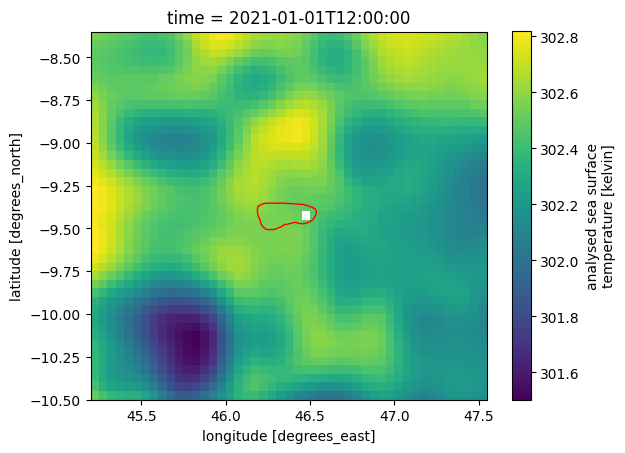

In [12]:
# Crop dataset to the defined area
# Note that we add a buffer of 1 degree, just to have a buffer area if needed
sliced_data = ds['analysed_sst'].sel(
    #time=slice(start_date, end_date),
    lon=slice(sel_area_lon[0]-1, sel_area_lon[1]+1),
    lat=slice(sel_area_lat[0]-1, sel_area_lat[1]+1))
sliced_data.plot()
sel_area.plot(ax=plt.gca(), facecolor='none', edgecolor='red')
plt.show()

In [13]:
#### OPTIONAL
# It is possible to already mask the data to the shapefile using the following code:
# area_mask = regionmask.mask_geopandas(sel_area, sliced_data)

# sliced_data = sliced_data.where(area_mask == 0)
    
# sliced_data.plot(col='time', col_wrap=1, figsize=(10, 10))
# plt.show()

## Download data for all areas and time steps

Now that we verified the data, we can proceed to download it for all regions and time steps we need.

In [10]:
# Create a folder to hold the results
if not os.path.exists("research/edna/sst"):
    os.makedirs("research/edna/sst")

In [ ]:
regions = range(len(shape_area))
regions = list(regions)

years = list(range(1992, 2022))
months = list(range(1, 13))

for reg_id in regions:
    # Print region name
    area_name = shape_area['name'][reg_id]
    area_is_buffer = shape_area['buffer'][reg_id]
    print(f"Processing region {area_name} - Is Buffer? {area_is_buffer}")
    sel_area = gpd.GeoDataFrame([shape_area.iloc[reg_id]], crs=shape_area.crs)

    for year in years:
        for month in months:
            available_days = os.listdir(f'eodata/CMEMS/REP/GLO/SST/SST_GLO_SST_L4_REP_OBSERVATIONS_010_011/{year}/{month:02}')
            for day in available_days:
                print(f"Processing {year} - {month:02} - {day}")
            
                file = os.listdir(f'eodata/CMEMS/REP/GLO/SST/SST_GLO_SST_L4_REP_OBSERVATIONS_010_011/{year}/{month:02}/{day}')
                ds = xr.open_dataset(f'eodata/CMEMS/REP/GLO/SST/SST_GLO_SST_L4_REP_OBSERVATIONS_010_011/{year}/{month:02}/{day}/{file[0]}')

                sel_area_lat = [float(sel_area.total_bounds[1]), float(sel_area.total_bounds[3])]
                sel_area_lon = [float(sel_area.total_bounds[0]), float(sel_area.total_bounds[2])]
  
                if 'longitude' in ds.dims:
                    ds = ds.rename({'longitude' : 'lon', 'latitude' : 'lat'})
                if 'Longitude' in ds.dims:
                    ds = ds.rename({'Longitude' : 'lon', 'Latitude' : 'lat'})

                sliced_data = ds['analysed_sst'].sel(
                    lon=slice(sel_area_lon[0]-1, sel_area_lon[1]+1),
                    lat=slice(sel_area_lat[0]-1, sel_area_lat[1]+1))

                sliced_data.to_dataframe().to_parquet(f'research/edna/sst/area={reg_id}_date={year}{month:02}{day}.parquet')

    # Merge region files
    print('Merging and saving file...')
    genfiles = os.listdir(f'research/edna/sst')

    pattern = f'area={reg_id}'
    matches = [string for string in genfiles if re.search(pattern, string)]
    matches = sorted(matches)

    parquet_files = [f'research/edna/sst/{file_name}' for file_name in matches]

    schema = pq.ParquetFile(parquet_files[0]).schema_arrow
    with pq.ParquetWriter(f'research/edna/sst/full_area={reg_id}.parquet', schema=schema) as writer:
        for file in parquet_files:
            writer.write_table(pq.read_table(file, schema=schema))
    
    for file_path in parquet_files:
        os.remove(file_path)

    # Save a base netcdf
    sliced_data.to_netcdf(f'research/edna/sst/baserast_area={reg_id}.nc')

Finally, we create a ZIP file with all resulting parquet files and download it. This is a **VERY IMPORTANT** step, as there is a limitation of disk space you can have on WEkEO (20GB). So, if you leave the files here, chances are that next time you try to open your WEkEO JupyterHub you will have problems.

In [12]:
def zip_and_remove_directory(directory_path, zip_filename):
    # Create a zip archive of the entire directory
    shutil.make_archive(zip_filename, 'zip', directory_path)

    # Remove the original directory and its contents
    shutil.rmtree(directory_path)

# Example usage:
directory_to_zip = "research/edna/sst"
zip_filename = "sst"

zip_and_remove_directory(directory_to_zip, zip_filename)

Remember to download and remove the zip file as well.